In [1]:
!pip install nb-black

In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
import sys

sys.path.insert(0, "../")

## Dataset

In [4]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [6]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [7]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [8]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [9]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Investigating Whitening Methods

In [10]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [11]:
signal = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signal.append(sig)
    label.append(lbl["label"])
signal = torch.vstack(signal)
label = torch.stack(label)

  0%|          | 0/2592 [00:00<?, ?it/s]

In [12]:
signal.size(), label.size()

(torch.Size([2592, 22, 1, 1, 1001]), torch.Size([2592]))

In [13]:
import matplotlib.pyplot as plt
import scipy.linalg as la

In [14]:
def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov

In [15]:
x = signal.squeeze()
sig = x.permute(0, 2, 1)
x = torch.mean(sig, axis=1)
x_mean = torch.mean(x, axis=0)
sig.size(), x_mean.size()

(torch.Size([2592, 1001, 22]), torch.Size([22]))

In [16]:
x = sig - x_mean
x_zero_centered = x.permute(0, 2, 1)
x_zero_centered.size()

torch.Size([2592, 22, 1001])

In [17]:
x = x_zero_centered
x_cov = calc_cov(x)
x_cov.shape

torch.Size([22, 22])

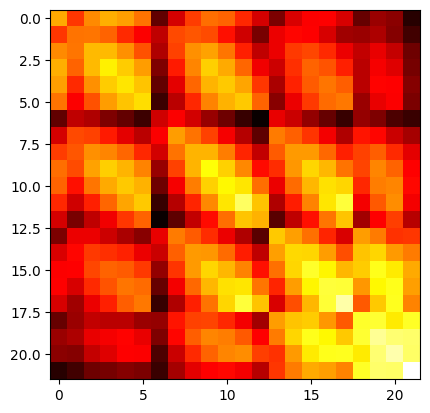

In [18]:
plt.imshow(x_cov, cmap="hot", interpolation="nearest")
plt.show()

In [19]:
lda, V = torch.linalg.eig(x_cov)
lda, V = lda.real, V.real
whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
# print(torch.allclose(whitening_mat, torch.sqrt(torch.inverse(x_cov))))
# whitening_mat = torch.inverse(torch.sqrt(x_cov))

whitening_mat.size()

torch.Size([22, 22])

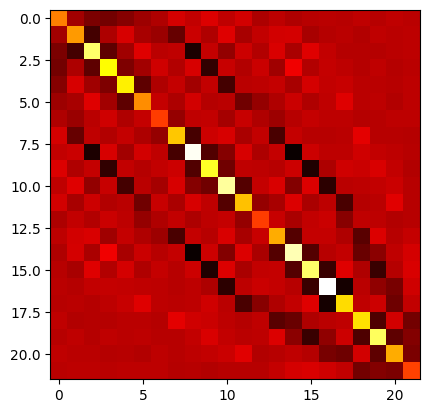

In [20]:
plt.imshow(whitening_mat, cmap="hot", interpolation="nearest")
plt.show()

In [21]:
whitened_signal = whitening_mat @ x_zero_centered
whitened_signal.size()

torch.Size([2592, 22, 1001])

In [22]:
x = whitened_signal
whitened_signal_cov = calc_cov(x)
whitened_signal_cov.shape

torch.Size([22, 22])

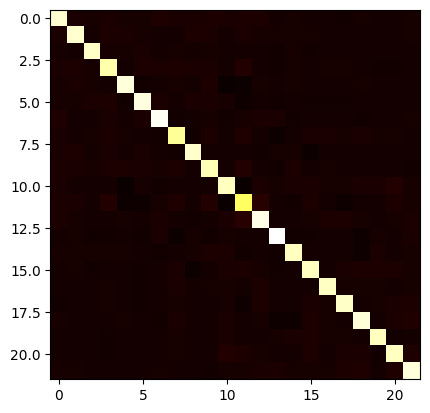

In [23]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

## Pytorch Dataset Transform Model

In [24]:
class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [25]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [26]:
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [27]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds_w = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [28]:
ds_w[0][0].size()

torch.Size([1, 22, 1, 1, 1001])

In [29]:
# train_dataset, _ = ds_w.get_train_test_subsets()

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=collate_fn,
#     num_workers=1,
# )

batch_size = 32
train_dataset, val_dataset = ds_w.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

In [30]:
signal = []
for sig, lbl in tqdm(train_dataloader):
    signal.append(sig)
signal = torch.vstack(signal)
signal.size()

  0%|          | 0/81 [00:00<?, ?it/s]

torch.Size([2592, 22, 1, 1, 1001])

In [31]:
whitened_signal_cov = calc_cov(signal.squeeze())
whitened_signal_cov.shape

torch.Size([22, 22])

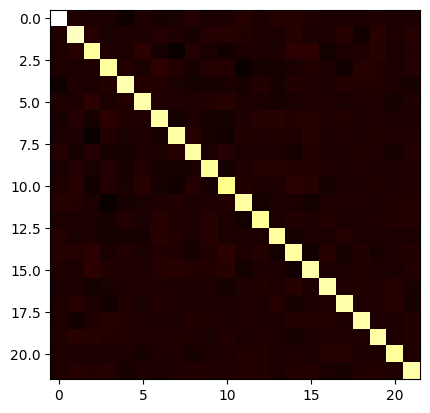

In [32]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

# Model

In [33]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

import torch.optim as optim

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [34]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [35]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [36]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [37]:
net = net.cuda()

In [38]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


81it [00:02, 31.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4055630336573095


Train -  [0.2492283950617284, -0.0010288065843622185, 0.6617582034623788, 0.2492283950617284, tensor(1.3876)]
Validation -  [0.2511574074074074, 0.0015432098765432167, 0.6606940713432912, 0.2511574074074074, tensor(1.3874)]

Epoch  1


81it [00:02, 36.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3981619793691753


Train -  [0.25, 0.0, 0.670231568803028, 0.25, tensor(1.3911)]
Validation -  [0.25, 0.0, 0.6672947864273739, 0.25, tensor(1.3910)]

Epoch  2


81it [00:02, 36.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3965409552609478


Train -  [0.26157407407407407, 0.015432098765432056, 0.6905162648287864, 0.26157407407407407, tensor(1.3769)]
Validation -  [0.2631172839506173, 0.017489711934156382, 0.6928865486714424, 0.2631172839506173, tensor(1.3763)]

Epoch  3


81it [00:02, 33.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.366649509947977


Train -  [0.38503086419753085, 0.18004115226337447, 0.6853176559404055, 0.38503086419753085, tensor(1.3440)]
Validation -  [0.3784722222222222, 0.17129629629629628, 0.6823222292079458, 0.3784722222222222, tensor(1.3429)]

Epoch  4


81it [00:02, 36.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3636995804162673


Train -  [0.37114197530864196, 0.16152263374485598, 0.7254935056584363, 0.3711419753086419, tensor(1.3303)]
Validation -  [0.4058641975308642, 0.20781893004115226, 0.7335311563277956, 0.4058641975308642, tensor(1.3238)]

Epoch  5


81it [00:02, 34.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3173312978979983


Train -  [0.45949074074074076, 0.279320987654321, 0.7606141324366205, 0.4594907407407407, tensor(1.2786)]
Validation -  [0.4425154320987654, 0.25668724279835387, 0.753837781969212, 0.4425154320987654, tensor(1.2787)]

Epoch  6


81it [00:02, 35.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2874192514537293


Train -  [0.503858024691358, 0.338477366255144, 0.7771599778362038, 0.503858024691358, tensor(1.2460)]
Validation -  [0.46875, 0.29166666666666663, 0.7608256887288524, 0.46875, tensor(1.2567)]

Epoch  7


81it [00:02, 31.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2894918182749806


Train -  [0.4089506172839506, 0.2119341563786008, 0.7784453906924758, 0.4089506172839506, tensor(1.2953)]
Validation -  [0.4050925925925926, 0.20679012345679015, 0.7606377489457908, 0.4050925925925926, tensor(1.2997)]

Epoch  8


81it [00:02, 28.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2318293812834187


Train -  [0.4868827160493827, 0.315843621399177, 0.7906114651602907, 0.4868827160493827, tensor(1.2444)]
Validation -  [0.4498456790123457, 0.2664609053497943, 0.7574697629299394, 0.4498456790123457, tensor(1.2675)]

Epoch  9


81it [00:02, 29.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3024870687060885


Train -  [0.44367283950617287, 0.2582304526748971, 0.7622887215490525, 0.44367283950617287, tensor(1.2870)]
Validation -  [0.4058641975308642, 0.20781893004115226, 0.7227239241985469, 0.4058641975308642, tensor(1.3154)]

Epoch  10


81it [00:02, 31.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2886362517321552


Train -  [0.45717592592592593, 0.2762345679012346, 0.7691050613156023, 0.45717592592592593, tensor(1.2738)]
Validation -  [0.4089506172839506, 0.2119341563786008, 0.7256449291584108, 0.4089506172839506, tensor(1.3080)]

Epoch  11


81it [00:02, 28.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.270485480626424


Train -  [0.439429012345679, 0.2525720164609053, 0.765468615048519, 0.439429012345679, tensor(1.2700)]
Validation -  [0.41203703703703703, 0.21604938271604934, 0.7251275489953259, 0.41203703703703703, tensor(1.2993)]

Epoch  12


81it [00:02, 29.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2428823827225486


Train -  [0.5266203703703703, 0.36882716049382713, 0.8076417466849566, 0.5266203703703703, tensor(1.2040)]
Validation -  [0.47800925925925924, 0.30401234567901236, 0.7645678139130214, 0.47800925925925924, tensor(1.2438)]

Epoch  13


81it [00:02, 28.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.207475640155651


Train -  [0.5563271604938271, 0.40843621399176955, 0.8095667898694305, 0.5563271604938271, tensor(1.1788)]
Validation -  [0.4984567901234568, 0.33127572016460904, 0.7641502581542448, 0.4984567901234568, tensor(1.2282)]

Epoch  14


81it [00:02, 27.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2117149255893849


Train -  [0.41358024691358025, 0.21810699588477367, 0.7963819309492964, 0.41358024691358025, tensor(1.3010)]
Validation -  [0.39699074074074076, 0.19598765432098764, 0.7587710524310319, 0.39699074074074076, tensor(1.3165)]

Epoch  15


81it [00:02, 29.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2070434682163191


Train -  [0.5524691358024691, 0.4032921810699589, 0.8170573908956968, 0.5524691358024691, tensor(1.1839)]
Validation -  [0.47685185185185186, 0.30246913580246915, 0.764215848543159, 0.47685185185185186, tensor(1.2411)]

Epoch  16


81it [00:02, 27.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.193291187286377


Train -  [0.5509259259259259, 0.4012345679012346, 0.8173604363537063, 0.5509259259259259, tensor(1.1780)]
Validation -  [0.49691358024691357, 0.3292181069958847, 0.7665414793222578, 0.49691358024691357, tensor(1.2224)]

Epoch  17


81it [00:02, 29.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1793703267603746


Train -  [0.6014660493827161, 0.4686213991769548, 0.8274288091246254, 0.6014660493827161, tensor(1.1402)]
Validation -  [0.5169753086419753, 0.3559670781893004, 0.7715600867499872, 0.5169753086419753, tensor(1.2052)]

Epoch  18


81it [00:02, 30.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1749131995954631


Train -  [0.5617283950617284, 0.4156378600823045, 0.8224455272316212, 0.5617283950617284, tensor(1.1636)]
Validation -  [0.5119598765432098, 0.34927983539094654, 0.768339112432048, 0.5119598765432098, tensor(1.2170)]

Epoch  19


81it [00:02, 27.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1923035633416823


Train -  [0.5725308641975309, 0.43004115226337447, 0.8249791420578672, 0.5725308641975309, tensor(1.1633)]
Validation -  [0.4957561728395062, 0.3276748971193416, 0.7613057587766092, 0.4957561728395062, tensor(1.2342)]

Epoch  20


81it [00:02, 29.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1891724710111264


Train -  [0.6091820987654321, 0.4789094650205762, 0.8289903763717421, 0.6091820987654321, tensor(1.1340)]
Validation -  [0.5135030864197531, 0.35133744855967075, 0.7677737054183814, 0.5135030864197531, tensor(1.2121)]

Epoch  21


81it [00:02, 30.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1623367306626873


Train -  [0.5895061728395061, 0.4526748971193416, 0.8323940313341461, 0.5895061728395061, tensor(1.1398)]
Validation -  [0.5073302469135802, 0.34310699588477367, 0.769841737635269, 0.5073302469135802, tensor(1.2124)]

Epoch  22


81it [00:02, 28.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1847677687068043


Train -  [0.5864197530864198, 0.44855967078189296, 0.8295801937268201, 0.5864197530864198, tensor(1.1452)]
Validation -  [0.5046296296296297, 0.3395061728395061, 0.7687758193936393, 0.5046296296296297, tensor(1.2221)]

Epoch  23


81it [00:02, 30.01it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1690672525653132
Train -  [0.6141975308641975, 0.48559670781893005, 0.8340795356398923, 0.6141975308641975, tensor(1.1259)]
Validation -  [0.5119598765432098, 0.34927983539094654, 0.7734386907483616, 0.5119598765432098, tensor(1.2116)]

Epoch  24


81it [00:02, 37.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1547007163365681


Train -  [0.527391975308642, 0.36985596707818935, 0.8200638320505005, 0.527391975308642, tensor(1.2002)]
Validation -  [0.46412037037037035, 0.2854938271604939, 0.7643311526761674, 0.46412037037037035, tensor(1.2594)]

Epoch  25


81it [00:02, 33.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1486927234096291


Train -  [0.5628858024691358, 0.41718106995884774, 0.8312159842884723, 0.5628858024691358, tensor(1.1667)]
Validation -  [0.5, 0.33333333333333337, 0.7701585759284663, 0.5, tensor(1.2281)]

Epoch  26


81it [00:02, 35.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1657032657552648


Train -  [0.5775462962962963, 0.43672839506172845, 0.8318549200134634, 0.5775462962962963, tensor(1.1518)]
Validation -  [0.5100308641975309, 0.3467078189300411, 0.7674827659020474, 0.5100308641975309, tensor(1.2169)]

Epoch  27


81it [00:02, 36.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1721190560011217


Train -  [0.5532407407407407, 0.404320987654321, 0.8259403736727126, 0.5532407407407407, tensor(1.1757)]
Validation -  [0.49151234567901236, 0.32201646090534974, 0.7639290766460904, 0.49151234567901236, tensor(1.2393)]

Epoch  28


81it [00:02, 36.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1410280090791207


Train -  [0.5652006172839507, 0.4202674897119342, 0.828936594237413, 0.5652006172839507, tensor(1.1660)]
Validation -  [0.4976851851851852, 0.33024691358024694, 0.7666962766092567, 0.4976851851851852, tensor(1.2297)]

Epoch  29


81it [00:02, 35.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1368797936557251


Train -  [0.625, 0.5, 0.8413118435007366, 0.625, tensor(1.1123)]
Validation -  [0.5092592592592593, 0.345679012345679, 0.7727194787379973, 0.5092592592592593, tensor(1.2160)]

Epoch  30


81it [00:02, 36.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.174991868160389


Train -  [0.5717592592592593, 0.42901234567901236, 0.8345996942158207, 0.5717592592592593, tensor(1.1561)]
Validation -  [0.5011574074074074, 0.3348765432098766, 0.7710678115315246, 0.5011574074074074, tensor(1.2246)]

Epoch  31


81it [00:02, 35.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.14455329120895


Train -  [0.6381172839506173, 0.5174897119341564, 0.845604292885993, 0.6381172839506173, tensor(1.1003)]
Validation -  [0.5212191358024691, 0.36162551440329216, 0.7733288442120103, 0.5212191358024691, tensor(1.2085)]

Epoch  32


81it [00:02, 35.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1497127112047172


Train -  [0.6242283950617284, 0.4989711934156379, 0.8464625247675659, 0.6242283950617284, tensor(1.1115)]
Validation -  [0.5119598765432098, 0.34927983539094654, 0.7738551549878068, 0.5119598765432098, tensor(1.2150)]

Epoch  33


81it [00:02, 36.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1443803921157931


Train -  [0.5814043209876543, 0.4418724279835391, 0.8398249957133059, 0.5814043209876543, tensor(1.1470)]
Validation -  [0.4810956790123457, 0.3081275720164609, 0.7723327832075902, 0.4810956790123457, tensor(1.2364)]

Epoch  34


81it [00:02, 35.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1570597519109278


Train -  [0.6018518518518519, 0.4691358024691358, 0.843487043070162, 0.6018518518518519, tensor(1.1319)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7682392880277397, 0.4930555555555556, tensor(1.2356)]

Epoch  35


81it [00:02, 27.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1178346136469899


Train -  [0.6358024691358025, 0.51440329218107, 0.8502368993865264, 0.6358024691358025, tensor(1.1009)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.7742998002718082, 0.5208333333333334, tensor(1.2070)]

Epoch  36


81it [00:02, 30.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1393882749993125


Train -  [0.6493055555555556, 0.5324074074074074, 0.8503852467865671, 0.6493055555555556, tensor(1.0921)]
Validation -  [0.5266203703703703, 0.36882716049382713, 0.7735830689871971, 0.5266203703703703, tensor(1.2023)]

Epoch  37


81it [00:02, 29.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1382363100110748


Train -  [0.5231481481481481, 0.3641975308641975, 0.833955598581263, 0.5231481481481481, tensor(1.2059)]
Validation -  [0.4471450617283951, 0.26286008230452673, 0.759060602740944, 0.4471450617283951, tensor(1.2765)]

Epoch  38


81it [00:02, 28.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.122577225720441


Train -  [0.6126543209876543, 0.4835390946502057, 0.8528299524018188, 0.6126543209876543, tensor(1.1199)]
Validation -  [0.5123456790123457, 0.34979423868312753, 0.7710230592389371, 0.5123456790123457, tensor(1.2161)]

Epoch  39


81it [00:02, 30.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1288973924554424


Train -  [0.6053240740740741, 0.4737654320987654, 0.8497253737362191, 0.6053240740740741, tensor(1.1249)]
Validation -  [0.5123456790123457, 0.34979423868312753, 0.7708215250787482, 0.5123456790123457, tensor(1.2160)]

Epoch  40


81it [00:02, 28.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1238825821582181


Train -  [0.6392746913580247, 0.5190329218106996, 0.8549190211730936, 0.6392746913580247, tensor(1.0944)]
Validation -  [0.5073302469135802, 0.34310699588477367, 0.7717829551516537, 0.5073302469135802, tensor(1.2165)]

Epoch  41


81it [00:02, 29.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1117584425726055


Train -  [0.5814043209876543, 0.4418724279835391, 0.8561397367017223, 0.5814043209876543, tensor(1.1480)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7713295777130009, 0.4965277777777778, tensor(1.2297)]

Epoch  42


81it [00:02, 28.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1575994344405185


Train -  [0.6149691358024691, 0.48662551440329216, 0.8528054428313774, 0.6149691358024691, tensor(1.1194)]
Validation -  [0.5023148148148148, 0.3364197530864198, 0.7719326917581161, 0.5023148148148148, tensor(1.2273)]

Epoch  43


81it [00:02, 35.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1240943007998996


Train -  [0.6350308641975309, 0.5133744855967078, 0.8574943121919931, 0.6350308641975309, tensor(1.1022)]
Validation -  [0.5119598765432098, 0.34927983539094654, 0.773335691015089, 0.5119598765432098, tensor(1.2145)]

Epoch  44


81it [00:02, 35.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.15440081887775


Train -  [0.5621141975308642, 0.41615226337448563, 0.8489973303421735, 0.5621141975308642, tensor(1.1650)]
Validation -  [0.4799382716049383, 0.3065843621399177, 0.7685582101305696, 0.4799382716049383, tensor(1.2467)]

Epoch  45


81it [00:02, 34.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1059802638159857


Train -  [0.6408179012345679, 0.5210905349794239, 0.8615551610209318, 0.6408179012345679, tensor(1.0985)]
Validation -  [0.5150462962962963, 0.3533950617283951, 0.771770749980948, 0.5150462962962963, tensor(1.2124)]

Epoch  46


81it [00:02, 33.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1212452863469535


Train -  [0.5621141975308642, 0.41615226337448563, 0.8437177505652086, 0.5621141975308642, tensor(1.1667)]
Validation -  [0.47453703703703703, 0.2993827160493827, 0.7639772027257025, 0.47453703703703703, tensor(1.2553)]

Epoch  47


81it [00:02, 37.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1253438908376812


Train -  [0.4540895061728395, 0.27211934156378603, 0.8436396573184982, 0.4540895061728395, tensor(1.2698)]
Validation -  [0.45524691358024694, 0.27366255144032925, 0.7672893685223289, 0.45524691358024694, tensor(1.2755)]

Epoch  48


81it [00:02, 35.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1447141553148812


Train -  [0.6469907407407407, 0.529320987654321, 0.8614289416946095, 0.6469907407407407, tensor(1.0932)]
Validation -  [0.5165895061728395, 0.3554526748971193, 0.773929279073312, 0.5165895061728395, tensor(1.2124)]

Epoch  49


81it [00:02, 34.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1055293002246338


Train -  [0.6458333333333334, 0.5277777777777778, 0.8620208428593203, 0.6458333333333334, tensor(1.0957)]
Validation -  [0.5162037037037037, 0.3549382716049383, 0.7729425455977239, 0.5162037037037037, tensor(1.2137)]

Epoch  50


81it [00:02, 36.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1132088001863456


Train -  [0.5767746913580247, 0.43569958847736623, 0.8529315629286693, 0.5767746913580247, tensor(1.1533)]
Validation -  [0.5169753086419753, 0.3559670781893004, 0.7733951292041357, 0.5169753086419753, tensor(1.2147)]

Epoch  51


81it [00:02, 37.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.11229004536146


Train -  [0.6184413580246914, 0.4912551440329218, 0.8583429188576437, 0.6184413580246914, tensor(1.1147)]
Validation -  [0.5246913580246914, 0.3662551440329218, 0.7754393464537926, 0.5246913580246914, tensor(1.2075)]

Epoch  52


81it [00:02, 35.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.092433445247603


Train -  [0.6658950617283951, 0.5545267489711934, 0.86724197673754, 0.6658950617283951, tensor(1.0725)]
Validation -  [0.5100308641975309, 0.3467078189300411, 0.7772272551186303, 0.5100308641975309, tensor(1.2163)]

Epoch  53


81it [00:02, 35.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1399116898760384


Train -  [0.6234567901234568, 0.4979423868312757, 0.8603573673982624, 0.6234567901234568, tensor(1.1089)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7797353680841335, 0.4965277777777778, tensor(1.2284)]

Epoch  54


81it [00:02, 36.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.10476408622883


Train -  [0.5347222222222222, 0.37962962962962965, 0.8421836697594371, 0.5347222222222222, tensor(1.1933)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7657485401425088, 0.4548611111111111, tensor(1.2705)]

Epoch  55


81it [00:02, 37.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1651716151355225


Train -  [0.6655092592592593, 0.5540123456790124, 0.8672517011824925, 0.6655092592592593, tensor(1.0710)]
Validation -  [0.5150462962962963, 0.3533950617283951, 0.776086220501194, 0.5150462962962963, tensor(1.2136)]

Epoch  56


81it [00:02, 37.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1274756803924655


Train -  [0.6589506172839507, 0.5452674897119342, 0.8656019193275923, 0.6589506172839507, tensor(1.0774)]
Validation -  [0.5227623456790124, 0.3636831275720165, 0.7799262847380988, 0.5227623456790124, tensor(1.2079)]

Epoch  57


81it [00:02, 35.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1379620477005288


Train -  [0.5100308641975309, 0.3467078189300411, 0.8370668255918814, 0.5100308641975309, tensor(1.2185)]
Validation -  [0.43287037037037035, 0.24382716049382713, 0.7682890017718336, 0.43287037037037035, tensor(1.2940)]

Epoch  58


81it [00:02, 39.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1134541711689514


Train -  [0.6481481481481481, 0.5308641975308642, 0.8675933467332215, 0.6481481481481481, tensor(1.0854)]
Validation -  [0.5231481481481481, 0.3641975308641975, 0.7768321251206625, 0.5231481481481481, tensor(1.2075)]

Epoch  59


81it [00:02, 33.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1004638075828552


Train -  [0.6446759259259259, 0.5262345679012346, 0.8671948429482295, 0.6446759259259259, tensor(1.0883)]
Validation -  [0.5154320987654321, 0.3539094650205762, 0.7786378950109231, 0.5154320987654321, tensor(1.2145)]

Epoch  60


81it [00:02, 34.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1102052765128054


Train -  [0.6705246913580247, 0.5606995884773662, 0.8695786219389829, 0.6705246913580247, tensor(1.0695)]
Validation -  [0.5235339506172839, 0.3647119341563786, 0.7778773044949957, 0.5235339506172839, tensor(1.2091)]

Epoch  61


81it [00:03, 22.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.118620451585746


Train -  [0.6419753086419753, 0.522633744855967, 0.8681345418635371, 0.6419753086419753, tensor(1.0927)]
Validation -  [0.5092592592592593, 0.345679012345679, 0.7754626652758725, 0.5092592592592593, tensor(1.2209)]

Epoch  62


81it [00:02, 34.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1241643230120342


Train -  [0.6851851851851852, 0.5802469135802469, 0.8710116875920846, 0.6851851851851852, tensor(1.0576)]
Validation -  [0.5165895061728395, 0.3554526748971193, 0.7767312091970228, 0.5165895061728395, tensor(1.2099)]

Epoch  63


81it [00:02, 37.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.091019074122111


Train -  [0.6736111111111112, 0.5648148148148149, 0.8717051992836458, 0.6736111111111112, tensor(1.0645)]
Validation -  [0.5162037037037037, 0.3549382716049383, 0.7770003183267287, 0.5162037037037037, tensor(1.2146)]

Epoch  64


81it [00:02, 32.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0909831111813768


Train -  [0.6635802469135802, 0.5514403292181069, 0.8695813011227962, 0.6635802469135802, tensor(1.0742)]
Validation -  [0.4976851851851852, 0.33024691358024694, 0.7757598562211045, 0.4976851851851852, tensor(1.2256)]

Epoch  65


81it [00:02, 36.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0866772017361206


Train -  [0.6462191358024691, 0.5282921810699588, 0.8686669056101712, 0.6462191358024691, tensor(1.0900)]
Validation -  [0.5246913580246914, 0.3662551440329218, 0.7776026385396027, 0.5246913580246914, tensor(1.2078)]

Epoch  66


81it [00:02, 35.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0910075064058657


Train -  [0.6354166666666666, 0.5138888888888888, 0.8665955988352892, 0.6354166666666666, tensor(1.0973)]
Validation -  [0.5162037037037037, 0.3549382716049383, 0.7738137764822435, 0.5162037037037037, tensor(1.2139)]

Epoch  67


81it [00:02, 36.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1027821405434315


Train -  [0.6072530864197531, 0.47633744855967075, 0.8585083336508662, 0.6072530864197531, tensor(1.1251)]
Validation -  [0.49537037037037035, 0.3271604938271605, 0.7725398741934664, 0.49537037037037035, tensor(1.2389)]

Epoch  68


81it [00:02, 35.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0890023605323131


Train -  [0.5841049382716049, 0.44547325102880664, 0.863737207393436, 0.5841049382716049, tensor(1.1472)]
Validation -  [0.49691358024691357, 0.3292181069958847, 0.7754679244144693, 0.49691358024691357, tensor(1.2338)]

Epoch  69


81it [00:02, 34.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1102529374169714


Train -  [0.6724537037037037, 0.5632716049382716, 0.8699066731125844, 0.6724537037037037, tensor(1.0668)]
Validation -  [0.5300925925925926, 0.3734567901234568, 0.7814278184219886, 0.5300925925925926, tensor(1.2000)]

Epoch  70


81it [00:02, 36.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1072981828524742


Train -  [0.595679012345679, 0.4609053497942387, 0.8646201473035107, 0.595679012345679, tensor(1.1354)]
Validation -  [0.4837962962962963, 0.31172839506172845, 0.7752642072156176, 0.4837962962962963, tensor(1.2471)]

Epoch  71


81it [00:02, 35.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.090752962194843


Train -  [0.6620370370370371, 0.5493827160493827, 0.8723068248933089, 0.6620370370370371, tensor(1.0747)]
Validation -  [0.5192901234567902, 0.35905349794238683, 0.7793582977696489, 0.5192901234567902, tensor(1.2083)]

Epoch  72


81it [00:02, 35.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0975183204368308


Train -  [0.6080246913580247, 0.47736625514403297, 0.8648389473149419, 0.6080246913580247, tensor(1.1213)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7739917933622922, 0.4861111111111111, tensor(1.2460)]

Epoch  73


81it [00:02, 30.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1304251551628113


Train -  [0.6550925925925926, 0.5401234567901234, 0.8685343356259208, 0.6550925925925926, tensor(1.0838)]
Validation -  [0.49614197530864196, 0.3281893004115226, 0.7759313239851648, 0.49614197530864196, tensor(1.2291)]

Epoch  74


81it [00:03, 25.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1457004289568207


Train -  [0.6323302469135802, 0.5097736625514404, 0.8682622496253112, 0.6323302469135802, tensor(1.0993)]
Validation -  [0.5196759259259259, 0.35956790123456794, 0.7755655657801148, 0.5196759259259259, tensor(1.2129)]

Epoch  75


81it [00:03, 23.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0938373141818576


Train -  [0.6597222222222222, 0.5462962962962963, 0.8732476153279479, 0.6597222222222222, tensor(1.0729)]
Validation -  [0.5042438271604939, 0.33899176954732513, 0.7788547104417518, 0.5042438271604939, tensor(1.2233)]

Epoch  76


81it [00:02, 34.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.090000961297824


Train -  [0.6890432098765432, 0.5853909465020577, 0.8754213264619214, 0.6890432098765432, tensor(1.0500)]
Validation -  [0.5162037037037037, 0.3549382716049383, 0.7791240180295178, 0.5162037037037037, tensor(1.2101)]

Epoch  77


81it [00:02, 35.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1028031611148221


Train -  [0.5868055555555556, 0.44907407407407407, 0.8643802115086623, 0.5868055555555556, tensor(1.1401)]
Validation -  [0.5096450617283951, 0.3461934156378601, 0.7740696881509425, 0.5096450617283951, tensor(1.2244)]

Epoch  78


81it [00:03, 25.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1198031674196691


Train -  [0.6890432098765432, 0.5853909465020577, 0.8734872534357059, 0.6890432098765432, tensor(1.0526)]
Validation -  [0.5246913580246914, 0.3662551440329218, 0.7812848293895747, 0.5246913580246914, tensor(1.2058)]

Epoch  79


81it [00:03, 26.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0892600203737801


Train -  [0.6763117283950617, 0.5684156378600823, 0.8739072899202358, 0.6763117283950617, tensor(1.0625)]
Validation -  [0.5219907407407407, 0.36265432098765427, 0.780117895995275, 0.5219907407407407, tensor(1.2082)]

Epoch  80


81it [00:03, 22.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1109528247221017


Train -  [0.6157407407407407, 0.48765432098765427, 0.8694445635192806, 0.6157407407407407, tensor(1.1175)]
Validation -  [0.49421296296296297, 0.3256172839506173, 0.7794440316516791, 0.49421296296296297, tensor(1.2345)]

Epoch  81


81it [00:04, 20.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0977808075186648


Train -  [0.6462191358024691, 0.5282921810699588, 0.8704352661560739, 0.6462191358024691, tensor(1.0889)]
Validation -  [0.5219907407407407, 0.36265432098765427, 0.7776689235317279, 0.5219907407407407, tensor(1.2074)]

Epoch  82


81it [00:02, 27.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0913770169387629


Train -  [0.6851851851851852, 0.5802469135802469, 0.8771185397932226, 0.6851851851851852, tensor(1.0519)]
Validation -  [0.5158179012345679, 0.3544238683127572, 0.7785880820377991, 0.5158179012345679, tensor(1.2170)]

Epoch  83


81it [00:02, 28.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0799924871067943


Train -  [0.6215277777777778, 0.49537037037037035, 0.8695275189884673, 0.6215277777777778, tensor(1.1137)]
Validation -  [0.5003858024691358, 0.33384773662551437, 0.7721292644667987, 0.5003858024691358, tensor(1.2316)]

Epoch  84


81it [00:03, 20.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1041962850241014


Train -  [0.6535493827160493, 0.5380658436213992, 0.8733002067139156, 0.6535493827160493, tensor(1.0804)]
Validation -  [0.5077160493827161, 0.3436213991769548, 0.7791153851038968, 0.5077160493827161, tensor(1.2179)]

Epoch  85


81it [00:03, 20.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0687443224000341


Train -  [0.6797839506172839, 0.573045267489712, 0.8777053802773968, 0.6797839506172839, tensor(1.0602)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7791729379413707, 0.5138888888888888, tensor(1.2202)]

Epoch  86


81it [00:03, 26.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0736359622743394


Train -  [0.6454475308641975, 0.5272633744855967, 0.8743605681298583, 0.6454475308641975, tensor(1.0931)]
Validation -  [0.5223765432098766, 0.3631687242798354, 0.7784534282439161, 0.5223765432098766, tensor(1.2095)]

Epoch  87


81it [00:03, 26.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0719738043384788


Train -  [0.5570987654320988, 0.40946502057613166, 0.8528476151691815, 0.5570987654320988, tensor(1.1704)]
Validation -  [0.46141975308641975, 0.28189300411522633, 0.767871446013057, 0.46141975308641975, tensor(1.2694)]

Epoch  88


81it [00:03, 20.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1537031244348597


Train -  [0.628858024691358, 0.5051440329218106, 0.8700286255906113, 0.628858024691358, tensor(1.1072)]
Validation -  [0.5223765432098766, 0.3631687242798354, 0.7849083758827414, 0.5223765432098766, tensor(1.2068)]

Epoch  89


81it [00:04, 19.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0760948238549408


Train -  [0.6743827160493827, 0.5658436213991769, 0.8788878926294263, 0.6743827160493827, tensor(1.0618)]
Validation -  [0.501929012345679, 0.3359053497942387, 0.7826490300957678, 0.501929012345679, tensor(1.2227)]

Epoch  90


81it [00:03, 26.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1101464055202626


Train -  [0.6736111111111112, 0.5648148148148149, 0.8797564443301326, 0.6736111111111112, tensor(1.0614)]
Validation -  [0.5154320987654321, 0.3539094650205762, 0.7848754318447391, 0.5154320987654321, tensor(1.2107)]

Epoch  91


81it [00:02, 28.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0712298655215604


Train -  [0.5266203703703703, 0.36882716049382713, 0.8598216298646039, 0.5266203703703703, tensor(1.2067)]
Validation -  [0.5100308641975309, 0.3467078189300411, 0.782940961902403, 0.5100308641975309, tensor(1.2206)]

Epoch  92


81it [00:04, 19.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0761199439013447


Train -  [0.6948302469135802, 0.5931069958847737, 0.8791464834819388, 0.6948302469135802, tensor(1.0429)]
Validation -  [0.5154320987654321, 0.3539094650205762, 0.7832969956625007, 0.5154320987654321, tensor(1.2121)]

Epoch  93


81it [00:04, 19.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.100207178680985


Train -  [0.6689814814814815, 0.558641975308642, 0.8794784045877153, 0.6689814814814815, tensor(1.0659)]
Validation -  [0.5050154320987654, 0.34002057613168724, 0.7849170088083625, 0.5050154320987654, tensor(1.2230)]

Epoch  94


81it [00:02, 27.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1006873963791648


Train -  [0.6604938271604939, 0.5473251028806585, 0.8734334713013769, 0.6604938271604939, tensor(1.0716)]
Validation -  [0.5023148148148148, 0.3364197530864198, 0.7788247432746531, 0.5023148148148148, tensor(1.2275)]

Epoch  95


81it [00:02, 27.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0781528890868763


Train -  [0.5925925925925926, 0.45679012345679015, 0.8664596550640147, 0.5925925925925926, tensor(1.1388)]
Validation -  [0.4845679012345679, 0.31275720164609055, 0.781982905616522, 0.48456790123456794, tensor(1.2481)]

Epoch  96


81it [00:04, 19.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1154756546020508


Train -  [0.6145833333333334, 0.48611111111111116, 0.8655481371932631, 0.6145833333333334, tensor(1.1197)]
Validation -  [0.48148148148148145, 0.308641975308642, 0.7743583453995835, 0.48148148148148145, tensor(1.2483)]

Epoch  97


81it [00:04, 19.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0899745240623568


Train -  [0.5837191358024691, 0.44495884773662553, 0.8609239651602907, 0.5837191358024691, tensor(1.1514)]
Validation -  [0.47685185185185186, 0.30246913580246915, 0.7753851674033431, 0.47685185185185186, tensor(1.2563)]

Epoch  98


81it [00:03, 26.31it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1125355436478133
Train -  [0.6929012345679012, 0.5905349794238683, 0.8783876790885535, 0.6929012345679012, tensor(1.0469)]
Validation -  [0.5300925925925926, 0.3734567901234568, 0.7862460824378906, 0.5300925925925926, tensor(1.2024)]

Epoch  99


81it [00:03, 26.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0640667618056874


Train -  [0.7044753086419753, 0.6059670781893004, 0.8816094472387339, 0.7044753086419753, tensor(1.0362)]
Validation -  [0.5177469135802469, 0.3569958847736625, 0.784671516187827, 0.5177469135802469, tensor(1.2111)]

Epoch  100


81it [00:04, 19.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0863212516278395


Train -  [0.7098765432098766, 0.6131687242798354, 0.8809532456625007, 0.7098765432098766, tensor(1.0343)]
Validation -  [0.5223765432098766, 0.3631687242798354, 0.7831004229538181, 0.5223765432098766, tensor(1.2075)]

Epoch  101


81it [00:04, 19.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.076726457219065


Train -  [0.6747685185185185, 0.566358024691358, 0.8793864192767871, 0.6747685185185185, tensor(1.0618)]
Validation -  [0.5266203703703703, 0.36882716049382713, 0.7846012620344966, 0.5266203703703703, tensor(1.2062)]

Epoch  102


81it [00:03, 25.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.100662648677826


Train -  [0.5057870370370371, 0.34104938271604934, 0.8517899329370522, 0.5057870370370371, tensor(1.2247)]
Validation -  [0.44598765432098764, 0.2613168724279835, 0.7765295758078037, 0.44598765432098764, tensor(1.2843)]

Epoch  103


81it [00:03, 24.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1024029917187161


Train -  [0.6446759259259259, 0.5262345679012346, 0.8706767896154041, 0.6446759259259259, tensor(1.0905)]
Validation -  [0.49614197530864196, 0.3281893004115226, 0.7778020888901589, 0.49614197530864196, tensor(1.2357)]

Epoch  104


81it [00:03, 20.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.068522490836956


Train -  [0.6624228395061729, 0.5498971193415638, 0.8775365916971498, 0.6624228395061729, tensor(1.0715)]
Validation -  [0.5266203703703703, 0.36882716049382713, 0.7844688905083068, 0.5266203703703703, tensor(1.2041)]

Epoch  105


81it [00:03, 22.02it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1358796071123194
Train -  [0.6851851851851852, 0.5802469135802469, 0.877680771477925, 0.6851851851851852, tensor(1.0536)]
Validation -  [0.5231481481481481, 0.3641975308641975, 0.7837811341004928, 0.5231481481481481, tensor(1.2089)]

Epoch  106


81it [00:03, 25.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.085217034375226


Train -  [0.6493055555555556, 0.5324074074074074, 0.874509014758929, 0.6493055555555556, tensor(1.0859)]
Validation -  [0.5154320987654321, 0.3539094650205762, 0.7795906921582076, 0.5154320987654321, tensor(1.2163)]

Epoch  107


81it [00:02, 27.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1193497431131056


Train -  [0.6427469135802469, 0.5236625514403292, 0.8733915966506629, 0.6427469135802469, tensor(1.0956)]
Validation -  [0.503858024691358, 0.338477366255144, 0.7772857010173754, 0.503858024691358, tensor(1.2239)]

Epoch  108


81it [00:04, 19.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1626312688544944


Train -  [0.6824845679012346, 0.5766460905349795, 0.8787978918991007, 0.6824845679012346, tensor(1.0499)]
Validation -  [0.5216049382716049, 0.36213991769547327, 0.783237359015394, 0.5216049382716049, tensor(1.2095)]

Epoch  109


81it [00:03, 23.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0627177166350095


Train -  [0.6774691358024691, 0.5699588477366255, 0.8791035173118935, 0.6774691358024691, tensor(1.0611)]
Validation -  [0.5092592592592593, 0.345679012345679, 0.7803624955545394, 0.5092592592592593, tensor(1.2214)]

Epoch  110


81it [00:03, 24.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.121282700403237


Train -  [0.5652006172839507, 0.4202674897119342, 0.8666183222831885, 0.5652006172839507, tensor(1.1625)]
Validation -  [0.5027006172839507, 0.3369341563786008, 0.7778239192767871, 0.5027006172839507, tensor(1.2325)]

Epoch  111


81it [00:02, 28.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0867334677849287


Train -  [0.6990740740740741, 0.5987654320987654, 0.8815646949461465, 0.6990740740740741, tensor(1.0395)]
Validation -  [0.5204475308641975, 0.36059670781893005, 0.7852366255144033, 0.5204475308641975, tensor(1.2096)]

Epoch  112


81it [00:03, 20.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.053815848297543


Train -  [0.6875, 0.5833333333333333, 0.8808258355878169, 0.6875, tensor(1.0509)]
Validation -  [0.5084876543209876, 0.3446502057613169, 0.7820534574569425, 0.5084876543209876, tensor(1.2175)]

Epoch  113


81it [00:03, 23.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0548965783766757


Train -  [0.6905864197530864, 0.5874485596707819, 0.8802138901590204, 0.6905864197530864, tensor(1.0507)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.7819099722793782, 0.5208333333333334, tensor(1.2107)]

Epoch  114


81it [00:03, 25.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0608379428769334


Train -  [0.7075617283950617, 0.6100823045267489, 0.882919071978357, 0.7075617283950617, tensor(1.0336)]
Validation -  [0.5235339506172839, 0.3647119341563786, 0.7860988265571813, 0.5235339506172839, tensor(1.2052)]

Epoch  115


81it [00:03, 25.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0796155399746366


Train -  [0.7071759259259259, 0.6095679012345678, 0.8824312620662502, 0.7071759259259259, tensor(1.0336)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7849681117588783, 0.5138888888888888, tensor(1.2159)]

Epoch  116


81it [00:03, 22.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.066666183648286


Train -  [0.6388888888888888, 0.5185185185185186, 0.8755909088744094, 0.6388888888888888, tensor(1.0933)]
Validation -  [0.5189043209876543, 0.3585390946502057, 0.7809879361314331, 0.5189043209876543, tensor(1.2146)]

Epoch  117


81it [00:03, 24.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0643824228533991


Train -  [0.6535493827160493, 0.5380658436213992, 0.8764530106881573, 0.6535493827160493, tensor(1.0824)]
Validation -  [0.5254629629629629, 0.3672839506172839, 0.7853439913250013, 0.5254629629629629, tensor(1.2030)]

Epoch  118


81it [00:03, 25.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0755865147084365


Train -  [0.5474537037037037, 0.3966049382716049, 0.8584909685705939, 0.5474537037037037, tensor(1.1849)]
Validation -  [0.4729938271604938, 0.2973251028806584, 0.7707396611288929, 0.4729938271604938, tensor(1.2602)]

Epoch  119


81it [00:03, 25.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.139074463903168


Train -  [0.5914351851851852, 0.45524691358024694, 0.8634137207552203, 0.5914351851851852, tensor(1.1472)]
Validation -  [0.4702932098765432, 0.29372427983539096, 0.7728524456383682, 0.4702932098765432, tensor(1.2620)]

Epoch  120


81it [00:03, 22.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0692554123607683


Train -  [0.6292438271604939, 0.5056584362139918, 0.8694170770779353, 0.6292438271604939, tensor(1.1054)]
Validation -  [0.48572530864197533, 0.31430041152263377, 0.7756361176205355, 0.48572530864197533, tensor(1.2460)]

Epoch  121


81it [00:03, 24.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0779337853561213


Train -  [0.49382716049382713, 0.3251028806584362, 0.8419611982738912, 0.49382716049382713, tensor(1.2363)]
Validation -  [0.4193672839506173, 0.22582304526748975, 0.7587009967357619, 0.4193672839506173, tensor(1.3106)]

Epoch  122


81it [00:03, 26.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.194355105912244


Train -  [0.6512345679012346, 0.5349794238683128, 0.8802754121576997, 0.6512345679012346, tensor(1.0801)]
Validation -  [0.49421296296296297, 0.3256172839506173, 0.7809926991248793, 0.49421296296296297, tensor(1.2335)]

Epoch  123


81it [00:02, 28.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0702959556638458


Train -  [0.654320987654321, 0.5390946502057613, 0.8741129916996901, 0.654320987654321, tensor(1.0820)]
Validation -  [0.49189814814814814, 0.32253086419753085, 0.7764809535830411, 0.49189814814814814, tensor(1.2412)]

Epoch  124


81it [00:04, 19.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.11577308177948


Train -  [0.6886574074074074, 0.5848765432098766, 0.8809563217624345, 0.6886574074074074, tensor(1.0502)]
Validation -  [0.5169753086419753, 0.3559670781893004, 0.7818281083295229, 0.5169753086419753, tensor(1.2124)]

Epoch  125


81it [00:03, 23.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.075787048280975


Train -  [0.6385030864197531, 0.5180041152263375, 0.8775154559137326, 0.6385030864197531, tensor(1.0952)]
Validation -  [0.4903549382716049, 0.32047325102880664, 0.7796255215477823, 0.4903549382716049, tensor(1.2410)]

Epoch  126


81it [00:03, 26.34it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.077581278335901
Train -  [0.5489969135802469, 0.39866255144032925, 0.8558036479766804, 0.5489969135802469, tensor(1.1828)]
Validation -  [0.4695216049382716, 0.29269547325102885, 0.7724722992239496, 0.46952160493827155, tensor(1.2610)]

Epoch  127


81it [00:03, 23.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1049649509382837


Train -  [0.6157407407407407, 0.48765432098765427, 0.8682977736180968, 0.6157407407407407, tensor(1.1129)]
Validation -  [0.5081018518518519, 0.3441358024691358, 0.7755079137136107, 0.5081018518518519, tensor(1.2269)]

Epoch  128


81it [00:03, 22.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0801125360123904


Train -  [0.6226851851851852, 0.49691358024691357, 0.8731633698813699, 0.6226851851851852, tensor(1.1127)]
Validation -  [0.5196759259259259, 0.35956790123456794, 0.7819041177666005, 0.5196759259259259, tensor(1.2095)]

Epoch  129


81it [00:03, 24.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0965819145426339


Train -  [0.7079475308641975, 0.61059670781893, 0.8833658010719911, 0.7079475308641976, tensor(1.0318)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.782175211476909, 0.5243055555555556, tensor(1.2093)]

Epoch  130


81it [00:03, 25.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0976705072838584


Train -  [0.6759259259259259, 0.5679012345679013, 0.8806057455989941, 0.6759259259259259, tensor(1.0597)]
Validation -  [0.5088734567901234, 0.345164609053498, 0.7831765316199257, 0.5088734567901234, tensor(1.2227)]

Epoch  131


81it [00:03, 24.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0637608266171115


Train -  [0.6998456790123457, 0.5997942386831276, 0.8821849756134735, 0.6998456790123457, tensor(1.0402)]
Validation -  [0.5320216049382716, 0.3760288065843621, 0.7849217718018088, 0.5320216049382716, tensor(1.2007)]

Epoch  132


81it [00:03, 26.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0719279330453755


Train -  [0.6929012345679012, 0.5905349794238683, 0.8801367892026114, 0.6929012345679012, tensor(1.0492)]
Validation -  [0.5154320987654321, 0.3539094650205762, 0.7814956910785957, 0.5154320987654321, tensor(1.2156)]

Epoch  133


81it [00:03, 26.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1078714934396154


Train -  [0.7075617283950617, 0.6100823045267489, 0.8841957526799777, 0.7075617283950617, tensor(1.0302)]
Validation -  [0.5084876543209876, 0.3446502057613169, 0.7814814020982573, 0.5084876543209876, tensor(1.2202)]

Epoch  134


81it [00:03, 26.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.079598030190409


Train -  [0.6658950617283951, 0.5545267489711934, 0.8753720096339481, 0.6658950617283951, tensor(1.0733)]
Validation -  [0.5073302469135802, 0.34310699588477367, 0.7837363818079053, 0.5073302469135802, tensor(1.2250)]

Epoch  135


81it [00:03, 24.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1011508556059848


Train -  [0.6990740740740741, 0.5987654320987654, 0.8812528181044557, 0.6990740740740741, tensor(1.0416)]
Validation -  [0.5165895061728395, 0.3554526748971193, 0.7794402609485342, 0.5165895061728395, tensor(1.2135)]

Epoch  136


81it [00:03, 25.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0962766180803747


Train -  [0.5389660493827161, 0.3852880658436214, 0.8562141584743179, 0.5389660493827161, tensor(1.1881)]
Validation -  [0.4664351851851852, 0.2885802469135802, 0.7720197156175381, 0.4664351851851852, tensor(1.2690)]

Epoch  137


81it [00:03, 25.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1361825517666193


Train -  [0.5675154320987654, 0.4233539094650206, 0.8604865635954886, 0.5675154320987654, tensor(1.1699)]
Validation -  [0.48649691358024694, 0.3153292181069959, 0.7751372932860844, 0.48649691358024694, tensor(1.2443)]

Epoch  138


81it [00:03, 26.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1283629845689844


Train -  [0.5933641975308642, 0.45781893004115226, 0.8634564884672051, 0.5933641975308642, tensor(1.1401)]
Validation -  [0.4810956790123457, 0.3081275720164609, 0.776908630702891, 0.4810956790123457, tensor(1.2549)]

Epoch  139


81it [00:03, 25.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1063512276720118


Train -  [0.691358024691358, 0.588477366255144, 0.8820339490296195, 0.691358024691358, tensor(1.0456)]
Validation -  [0.5235339506172839, 0.3647119341563786, 0.7873003908829955, 0.5235339506172839, tensor(1.2113)]

Epoch  140


81it [00:03, 26.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.059838655554218


Train -  [0.7125771604938271, 0.6167695473251029, 0.8855332607770665, 0.7125771604938271, tensor(1.0278)]
Validation -  [0.5196759259259259, 0.35956790123456794, 0.7845339847520703, 0.5196759259259259, tensor(1.2136)]

Epoch  141


81it [00:03, 25.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.075486409811326


Train -  [0.6369598765432098, 0.5159465020576132, 0.8808229579459431, 0.6369598765432098, tensor(1.0962)]
Validation -  [0.5030864197530864, 0.3374485596707819, 0.7850179247320023, 0.5030864197530864, tensor(1.2302)]

Epoch  142


81it [00:03, 25.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.055624292956458


Train -  [0.6685956790123457, 0.5581275720164609, 0.8774253559543769, 0.6685956790123457, tensor(1.0661)]
Validation -  [0.5030864197530864, 0.3374485596707819, 0.7777124850759538, 0.5030864197530864, tensor(1.2298)]

Epoch  143


81it [00:02, 27.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.067529668778549


Train -  [0.7175925925925926, 0.6234567901234568, 0.8841877151285373, 0.7175925925925924, tensor(1.0234)]
Validation -  [0.5169753086419753, 0.3559670781893004, 0.7824168341652695, 0.5169753086419753, tensor(1.2161)]

Epoch  144


81it [00:03, 23.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0542660311416343


Train -  [0.6840277777777778, 0.5787037037037037, 0.8808646341385967, 0.6840277777777778, tensor(1.0570)]
Validation -  [0.5254629629629629, 0.3672839506172839, 0.7860899951734999, 0.5254629629629629, tensor(1.2021)]

Epoch  145


81it [00:03, 25.75it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0639677297921828
Train -  [0.5949074074074074, 0.4598765432098766, 0.8776211348308185, 0.5949074074074074, tensor(1.1346)]
Validation -  [0.49537037037037035, 0.3271604938271605, 0.7831013160150891, 0.49537037037037035, tensor(1.2387)]

Epoch  146


81it [00:02, 27.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0743256866196056


Train -  [0.6628086419753086, 0.5504115226337449, 0.8798655962632729, 0.6628086419753086, tensor(1.0697)]
Validation -  [0.527391975308642, 0.36985596707818935, 0.7879754459749531, 0.527391975308642, tensor(1.2023)]

Epoch  147


81it [00:02, 28.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0840219921535916


Train -  [0.6612654320987654, 0.5483539094650205, 0.8770508655946755, 0.6612654320987654, tensor(1.0752)]
Validation -  [0.4976851851851852, 0.33024691358024694, 0.7809209565360972, 0.4976851851851852, tensor(1.2360)]

Epoch  148


81it [00:03, 23.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0770394699073131


Train -  [0.5864197530864198, 0.44855967078189296, 0.8683543341652695, 0.5864197530864198, tensor(1.1497)]
Validation -  [0.49537037037037035, 0.3271604938271605, 0.7792872497840776, 0.49537037037037035, tensor(1.2406)]

Epoch  149


81it [00:02, 27.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0671250179961875


Train -  [0.6284722222222222, 0.5046296296296297, 0.8769434997840776, 0.6284722222222222, tensor(1.1054)]
Validation -  [0.5057870370370371, 0.34104938271604934, 0.7833632806546258, 0.5057870370370371, tensor(1.2259)]

Epoch  150


81it [00:03, 26.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0685321210343162


Train -  [0.6157407407407407, 0.48765432098765427, 0.876088641689529, 0.6157407407407407, tensor(1.1159)]
Validation -  [0.535108024691358, 0.38014403292181065, 0.7876664467751359, 0.535108024691358, tensor(1.1989)]

Epoch  151


81it [00:03, 25.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0685411721100042


Train -  [0.6956018518518519, 0.5941358024691358, 0.885013102201138, 0.6956018518518519, tensor(1.0403)]
Validation -  [0.5374228395061729, 0.3832304526748971, 0.7875566994678149, 0.5374228395061729, tensor(1.1959)]

Epoch  152


81it [00:02, 28.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0597636427408383


Train -  [0.7175925925925926, 0.6234567901234568, 0.8867579454669003, 0.7175925925925924, tensor(1.0225)]
Validation -  [0.5262345679012346, 0.36831275720164613, 0.7886590347635016, 0.5262345679012346, tensor(1.2045)]

Epoch  153


81it [00:03, 25.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0524892939461603


Train -  [0.7110339506172839, 0.6147119341563786, 0.8860928132779555, 0.7110339506172839, tensor(1.0304)]
Validation -  [0.5289351851851852, 0.37191358024691357, 0.7890522794098969, 0.5289351851851852, tensor(1.2067)]

Epoch  154


81it [00:02, 27.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1139465320257493


Train -  [0.621141975308642, 0.49485596707818935, 0.8734570878105472, 0.621141975308642, tensor(1.1151)]
Validation -  [0.4949845679012346, 0.3266460905349794, 0.7838050482967536, 0.4949845679012346, tensor(1.2375)]

Epoch  155


81it [00:03, 26.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0776277052031622


Train -  [0.6751543209876543, 0.5668724279835391, 0.8819127903838337, 0.6751543209876543, tensor(1.0607)]
Validation -  [0.5077160493827161, 0.3436213991769548, 0.7843510064205151, 0.5077160493827161, tensor(1.2259)]

Epoch  156


81it [00:03, 23.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0886516644630904


Train -  [0.6736111111111112, 0.5648148148148149, 0.8844991950541075, 0.6736111111111112, tensor(1.0613)]
Validation -  [0.5142746913580247, 0.35236625514403297, 0.7873253965985877, 0.5142746913580247, tensor(1.2192)]

Epoch  157


81it [00:03, 24.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0579992444426924


Train -  [0.6724537037037037, 0.5632716049382716, 0.8798744276469543, 0.6724537037037037, tensor(1.0654)]
Validation -  [0.5154320987654321, 0.3539094650205762, 0.7851758973479652, 0.5154320987654321, tensor(1.2178)]

Epoch  158


81it [00:03, 26.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0566771273259763


Train -  [0.7017746913580247, 0.602366255144033, 0.8859150940849971, 0.7017746913580247, tensor(1.0350)]
Validation -  [0.5239197530864198, 0.3652263374485597, 0.7868694392051516, 0.5239197530864198, tensor(1.2112)]

Epoch  159


81it [00:03, 23.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0925408174962172


Train -  [0.6431327160493827, 0.5241769547325104, 0.8786099521160392, 0.6431327160493827, tensor(1.0885)]
Validation -  [0.5181327160493827, 0.3575102880658436, 0.784715772335264, 0.5181327160493827, tensor(1.2146)]

Epoch  160


81it [00:03, 20.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.063094780768877


Train -  [0.7152777777777778, 0.6203703703703703, 0.8863492210918051, 0.7152777777777778, tensor(1.0232)]
Validation -  [0.5158179012345679, 0.3544238683127572, 0.7881098020817456, 0.5158179012345679, tensor(1.2133)]

Epoch  161


81it [00:03, 25.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.071605650731075


Train -  [0.652391975308642, 0.536522633744856, 0.8776257985952345, 0.652391975308642, tensor(1.0802)]
Validation -  [0.498070987654321, 0.33076131687242794, 0.7825186431501804, 0.498070987654321, tensor(1.2357)]

Epoch  162


81it [00:03, 25.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0705602330926023


Train -  [0.6207561728395061, 0.49434156378600824, 0.8724339372809022, 0.6207561728395061, tensor(1.1180)]
Validation -  [0.5181327160493827, 0.3575102880658436, 0.7819746696070213, 0.5181327160493827, tensor(1.2163)]

Epoch  163


81it [00:03, 20.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1112688250011868


Train -  [0.7091049382716049, 0.6121399176954733, 0.8861061099679927, 0.7091049382716049, tensor(1.0327)]
Validation -  [0.5339506172839507, 0.37860082304526754, 0.7861823774005487, 0.5339506172839507, tensor(1.1992)]

Epoch  164


81it [00:04, 19.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0455438126752405


Train -  [0.6439043209876543, 0.5252057613168724, 0.8770953202001728, 0.6439043209876543, tensor(1.0950)]
Validation -  [0.533179012345679, 0.3775720164609053, 0.783606193320378, 0.533179012345679, tensor(1.2058)]

Epoch  165


81it [00:03, 24.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0858104059725633


Train -  [0.5324074074074074, 0.3765432098765432, 0.8618664424884418, 0.5324074074074074, tensor(1.2009)]
Validation -  [0.4799382716049383, 0.3065843621399177, 0.7732447972234924, 0.4799382716049383, tensor(1.2558)]

Epoch  166


81it [00:03, 25.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1760556749355646


Train -  [0.49189814814814814, 0.32253086419753085, 0.8531853907877357, 0.49189814814814814, tensor(1.2414)]
Validation -  [0.44212962962962965, 0.25617283950617287, 0.7736127384672052, 0.44212962962962965, tensor(1.2925)]

Epoch  167


81it [00:04, 19.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0627422045778345


Train -  [0.7318672839506173, 0.6424897119341564, 0.887961395144287, 0.7318672839506173, tensor(1.0094)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.7881938490702638, 0.5347222222222222, tensor(1.1991)]

Epoch  168


81it [00:03, 20.44it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.036491123246558
Train -  [0.6801697530864198, 0.5735596707818931, 0.8837904020919066, 0.6801697530864198, tensor(1.0573)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.7850353890413047, 0.5277777777777778, tensor(1.2076)]

Epoch  169


81it [00:02, 27.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0573344480844191


Train -  [0.7125771604938271, 0.6167695473251029, 0.8854770971460142, 0.7125771604938271, tensor(1.0283)]
Validation -  [0.5127314814814815, 0.35030864197530864, 0.782633451138038, 0.5127314814814815, tensor(1.2172)]

Epoch  170


81it [00:02, 29.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0720208279880477


Train -  [0.7056327160493827, 0.6075102880658436, 0.8853159492010871, 0.7056327160493827, tensor(1.0355)]
Validation -  [0.5246913580246914, 0.3662551440329218, 0.7876908571165472, 0.5246913580246914, tensor(1.2087)]

Epoch  171


81it [00:04, 19.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.07969143876323


Train -  [0.7229938271604939, 0.6306584362139918, 0.8885857442018493, 0.722993827160494, tensor(1.0171)]
Validation -  [0.5254629629629629, 0.3672839506172839, 0.7879414104176192, 0.5254629629629629, tensor(1.2062)]

Epoch  172


81it [00:03, 23.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0457170811700232


Train -  [0.6778549382716049, 0.5704732510288066, 0.8832981268734441, 0.6778549382716049, tensor(1.0562)]
Validation -  [0.5204475308641975, 0.36059670781893005, 0.7822642199169334, 0.5204475308641975, tensor(1.2133)]

Epoch  173


81it [00:02, 27.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.07654979199539


Train -  [0.6307870370370371, 0.507716049382716, 0.8734061833180917, 0.6307870370370371, tensor(1.1042)]
Validation -  [0.5258487654320988, 0.367798353909465, 0.7801991645709495, 0.5258487654320988, tensor(1.2106)]

Epoch  174


81it [00:02, 27.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0450059256435913


Train -  [0.6886574074074074, 0.5848765432098766, 0.88575384691104, 0.6886574074074074, tensor(1.0470)]
Validation -  [0.5227623456790124, 0.3636831275720165, 0.7856406861250824, 0.5227623456790124, tensor(1.2132)]

Epoch  175


81it [00:03, 23.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0820167108818337


Train -  [0.59375, 0.45833333333333337, 0.8776786876682924, 0.59375, tensor(1.1340)]
Validation -  [0.49691358024691357, 0.3292181069958847, 0.781978241852106, 0.49691358024691357, tensor(1.2326)]

Epoch  176


81it [00:02, 28.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0577735503514607


Train -  [0.6921296296296297, 0.5895061728395061, 0.8843644420311945, 0.6921296296296297, tensor(1.0447)]
Validation -  [0.527391975308642, 0.36985596707818935, 0.7866387317101051, 0.527391975308642, tensor(1.2056)]

Epoch  177


81it [00:02, 27.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0319911182662587


Train -  [0.6010802469135802, 0.46810699588477367, 0.8674390455913732, 0.6010802469135802, tensor(1.1338)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7718402103020373, 0.4756944444444444, tensor(1.2598)]

Epoch  178


81it [00:03, 26.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.055171115162932


Train -  [0.7060185185185185, 0.6080246913580247, 0.8880929728382361, 0.7060185185185185, tensor(1.0307)]
Validation -  [0.5054012345679012, 0.34053497942386834, 0.7840537162462531, 0.5054012345679012, tensor(1.2253)]

Epoch  179


81it [00:03, 21.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0482258796691895


Train -  [0.7075617283950617, 0.6100823045267489, 0.8879136659807956, 0.7075617283950617, tensor(1.0283)]
Validation -  [0.5127314814814815, 0.35030864197530864, 0.7866471661776662, 0.5127314814814815, tensor(1.2188)]

Epoch  180


81it [00:03, 25.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0505007601078646


Train -  [0.6280864197530864, 0.5041152263374485, 0.8754913821571915, 0.6280864197530864, tensor(1.1052)]
Validation -  [0.49228395061728397, 0.32304526748971196, 0.7761738397347966, 0.49228395061728397, tensor(1.2417)]

Epoch  181


81it [00:03, 25.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.029606228257403


Train -  [0.6577932098765432, 0.543724279835391, 0.8804115543870344, 0.6577932098765432, tensor(1.0802)]
Validation -  [0.49189814814814814, 0.32253086419753085, 0.7820705248501244, 0.49189814814814814, tensor(1.2435)]

Epoch  182


81it [00:03, 25.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0666361738134313


Train -  [0.6743827160493827, 0.5658436213991769, 0.8819661756020425, 0.6743827160493827, tensor(1.0582)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7806176133909973, 0.4895833333333333, tensor(1.2388)]

Epoch  183


81it [00:03, 23.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0644712190569183


Train -  [0.5671296296296297, 0.4228395061728395, 0.860865023116395, 0.5671296296296297, tensor(1.1695)]
Validation -  [0.5057870370370371, 0.34104938271604934, 0.7746657569349185, 0.5057870370370371, tensor(1.2300)]

Epoch  184


81it [00:03, 25.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.081667611628403


Train -  [0.6790123456790124, 0.5720164609053497, 0.8818284457082254, 0.6790123456790124, tensor(1.0574)]
Validation -  [0.5262345679012346, 0.36831275720164613, 0.7836425111454046, 0.5262345679012346, tensor(1.2067)]

Epoch  185


81it [00:03, 26.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0400932482731196


Train -  [0.7337962962962963, 0.6450617283950617, 0.8900217867258549, 0.7337962962962963, tensor(1.0092)]
Validation -  [0.5216049382716049, 0.36213991769547327, 0.7833689367093432, 0.5216049382716049, tensor(1.2109)]

Epoch  186


81it [00:03, 25.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0324024675804893


Train -  [0.7287808641975309, 0.6383744855967078, 0.8891794314891023, 0.7287808641975309, tensor(1.0110)]
Validation -  [0.5196759259259259, 0.35956790123456794, 0.7870705764492202, 0.5196759259259259, tensor(1.2134)]

Epoch  187


81it [00:03, 24.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0378646857944536


Train -  [0.7229938271604939, 0.6306584362139918, 0.8882969877241782, 0.722993827160494, tensor(1.0143)]
Validation -  [0.5061728395061729, 0.34156378600823045, 0.782202400231164, 0.5061728395061729, tensor(1.2246)]

Epoch  188


81it [00:03, 24.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0419645677378149


Train -  [0.6948302469135802, 0.5931069958847737, 0.8856449926649901, 0.6948302469135802, tensor(1.0437)]
Validation -  [0.5065586419753086, 0.34207818930041156, 0.7830592429063151, 0.5065586419753086, tensor(1.2258)]

Epoch  189


81it [00:02, 28.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0363412992453869


Train -  [0.7457561728395061, 0.6610082304526749, 0.8892861026964894, 0.7457561728395061, tensor(1.0022)]
Validation -  [0.5266203703703703, 0.36882716049382713, 0.7831372369239953, 0.5266203703703703, tensor(1.2094)]

Epoch  190


81it [00:03, 26.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0473378506707556


Train -  [0.6786265432098766, 0.5715020576131687, 0.8868185744043083, 0.6786265432098766, tensor(1.0526)]
Validation -  [0.5200617283950617, 0.36008230452674894, 0.7847269852156682, 0.5200617283950617, tensor(1.2116)]

Epoch  191


81it [00:02, 29.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.042921487931852


Train -  [0.6936728395061729, 0.5915637860082305, 0.8873447859510746, 0.6936728395061729, tensor(1.0403)]
Validation -  [0.5154320987654321, 0.3539094650205762, 0.7825750052392928, 0.5154320987654321, tensor(1.2151)]

Epoch  192


81it [00:03, 25.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.049017893679348


Train -  [0.7052469135802469, 0.6069958847736625, 0.8870433281575472, 0.7052469135802469, tensor(1.0324)]
Validation -  [0.5108024691358025, 0.3477366255144033, 0.7805949891721283, 0.5108024691358025, tensor(1.2228)]

Epoch  193


81it [00:03, 26.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0641367177904388


Train -  [0.6828703703703703, 0.5771604938271605, 0.8843086753162628, 0.6828703703703703, tensor(1.0552)]
Validation -  [0.529320987654321, 0.3724279835390947, 0.7839489303904383, 0.529320987654321, tensor(1.2043)]

Epoch  194


81it [00:03, 24.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.082067455774472


Train -  [0.7114197530864198, 0.6152263374485596, 0.886358449391607, 0.7114197530864198, tensor(1.0306)]
Validation -  [0.535108024691358, 0.38014403292181065, 0.7847720351953462, 0.535108024691358, tensor(1.2008)]

Epoch  195


81it [00:03, 26.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0410901962974926


Train -  [0.7418981481481481, 0.6558641975308642, 0.8904706988581518, 0.7418981481481481, tensor(0.9999)]
Validation -  [0.5150462962962963, 0.3533950617283951, 0.7821820582799878, 0.5150462962962963, tensor(1.2167)]

Epoch  196


81it [00:03, 25.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0601461522373152


Train -  [0.7129629629629629, 0.617283950617284, 0.8886897362254229, 0.7129629629629629, tensor(1.0256)]
Validation -  [0.5158179012345679, 0.3544238683127572, 0.7822111323858152, 0.5158179012345679, tensor(1.2177)]

Epoch  197


81it [00:02, 27.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0658265668668865


Train -  [0.6628086419753086, 0.5504115226337449, 0.8831890741693339, 0.6628086419753086, tensor(1.0764)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.7819671282007317, 0.5277777777777778, tensor(1.2045)]

Epoch  198


81it [00:03, 24.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0563294652067585


Train -  [0.6385030864197531, 0.5180041152263375, 0.8755111287341869, 0.6385030864197531, tensor(1.0933)]
Validation -  [0.4845679012345679, 0.31275720164609055, 0.7687259071914851, 0.48456790123456794, tensor(1.2519)]

Epoch  199


81it [00:03, 24.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0886761788968686


Train -  [0.6886574074074074, 0.5848765432098766, 0.8848967065487985, 0.6886574074074074, tensor(1.0496)]
Validation -  [0.49266975308641975, 0.32355967078189296, 0.7778328498894985, 0.49266975308641975, tensor(1.2398)]

Epoch  200


81it [00:03, 25.64it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0059723074053541
Train -  [0.7345679012345679, 0.6460905349794239, 0.8906630047185388, 0.7345679012345679, tensor(1.0048)]
Validation -  [0.5223765432098766, 0.3631687242798354, 0.7810346730046234, 0.5223765432098766, tensor(1.2110)]

Epoch  201


81it [00:03, 25.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9975967046655254


Train -  [0.7527006172839507, 0.6702674897119342, 0.8918796518569323, 0.7527006172839507, tensor(0.9934)]
Validation -  [0.5216049382716049, 0.36213991769547327, 0.7806743723962302, 0.5216049382716049, tensor(1.2132)]

Epoch  202


81it [00:02, 27.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9980503070501634


Train -  [0.7449845679012346, 0.6599794238683128, 0.8921876587664482, 0.7449845679012346, tensor(0.9967)]
Validation -  [0.5185185185185185, 0.3580246913580247, 0.7806856845056648, 0.5185185185185185, tensor(1.2152)]

Epoch  203


81it [00:03, 21.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9960164648515207


Train -  [0.7465277777777778, 0.662037037037037, 0.8921989708758827, 0.7465277777777777, tensor(0.9950)]
Validation -  [0.5219907407407407, 0.36265432098765427, 0.7807985079129196, 0.5219907407407407, tensor(1.2129)]

Epoch  204


81it [00:03, 25.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9971781270003613


Train -  [0.7496141975308642, 0.6661522633744856, 0.8911263050602042, 0.7496141975308642, tensor(0.9971)]
Validation -  [0.5135030864197531, 0.35133744855967075, 0.7793376581313822, 0.5135030864197531, tensor(1.2211)]

Epoch  205


81it [00:03, 26.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9956034745699094


Train -  [0.7546296296296297, 0.6728395061728395, 0.8923327316084947, 0.7546296296296298, tensor(0.9897)]
Validation -  [0.5239197530864198, 0.3652263374485597, 0.7804678767845349, 0.5239197530864198, tensor(1.2125)]

Epoch  206


81it [00:03, 21.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9950127748795498


Train -  [0.7550154320987654, 0.6733539094650205, 0.8922638666615861, 0.7550154320987654, tensor(0.9899)]
Validation -  [0.5246913580246914, 0.3662551440329218, 0.7800514125450896, 0.5246913580246914, tensor(1.2137)]

Epoch  207


81it [00:04, 20.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.99211605095569


Train -  [0.7581018518518519, 0.6774691358024691, 0.8923755985495099, 0.7581018518518519, tensor(0.9882)]
Validation -  [0.5239197530864198, 0.3652263374485597, 0.7806024313493878, 0.5239197530864198, tensor(1.2134)]

Epoch  208


81it [00:02, 28.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9934798640969359


Train -  [0.7534722222222222, 0.6712962962962963, 0.8924106263971447, 0.7534722222222221, tensor(0.9926)]
Validation -  [0.5150462962962963, 0.3533950617283951, 0.780458648484733, 0.5150462962962963, tensor(1.2186)]

Epoch  209


81it [00:02, 28.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9934599554097211


Train -  [0.7561728395061729, 0.6748971193415638, 0.8923910782782096, 0.7561728395061729, tensor(0.9903)]
Validation -  [0.5169753086419753, 0.3559670781893004, 0.7811957217205203, 0.5169753086419753, tensor(1.2163)]

Epoch  210


81it [00:03, 22.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9904770233013012


Train -  [0.7515432098765432, 0.668724279835391, 0.892437219777219, 0.7515432098765433, tensor(0.9909)]
Validation -  [0.5227623456790124, 0.3636831275720165, 0.7810107588083625, 0.5227623456790124, tensor(1.2116)]

Epoch  211


81it [00:04, 20.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9903196751335521


Train -  [0.7469135802469136, 0.6625514403292181, 0.892022541660316, 0.7469135802469135, tensor(0.9954)]
Validation -  [0.5281635802469136, 0.37088477366255146, 0.7813016983246963, 0.5281635802469136, tensor(1.2075)]

Epoch  212


81it [00:03, 25.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9922779783790494


Train -  [0.746141975308642, 0.661522633744856, 0.8923198318345781, 0.746141975308642, tensor(0.9938)]
Validation -  [0.5154320987654321, 0.3539094650205762, 0.7813979504839201, 0.5154320987654321, tensor(1.2122)]

Epoch  213


81it [00:02, 28.49it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9915704138485002
Train -  [0.7511574074074074, 0.6682098765432098, 0.8918232897678199, 0.7511574074074074, tensor(0.9944)]
Validation -  [0.5084876543209876, 0.3446502057613169, 0.7811981032172434, 0.5084876543209876, tensor(1.2216)]

Epoch  214


81it [00:03, 20.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9938657695864453


Train -  [0.7642746913580247, 0.6856995884773662, 0.8926245641860997, 0.7642746913580247, tensor(0.9839)]
Validation -  [0.5196759259259259, 0.35956790123456794, 0.7805879439109892, 0.5196759259259259, tensor(1.2151)]

Epoch  215


81it [00:04, 18.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9878514092645527


Train -  [0.7631172839506173, 0.6841563786008231, 0.8925350596009246, 0.7631172839506173, tensor(0.9844)]
Validation -  [0.5189043209876543, 0.3585390946502057, 0.7810425120980032, 0.5189043209876543, tensor(1.2160)]

Epoch  216


81it [00:02, 28.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9883182100307795


Train -  [0.7638888888888888, 0.6851851851851851, 0.8927342122643904, 0.763888888888889, tensor(0.9858)]
Validation -  [0.5142746913580247, 0.35236625514403297, 0.7814600678567799, 0.5142746913580247, tensor(1.2161)]

Epoch  217


81it [00:03, 26.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.98709570404924


Train -  [0.7646604938271605, 0.6862139917695473, 0.8927745984796526, 0.7646604938271604, tensor(0.9834)]
Validation -  [0.5262345679012346, 0.36831275720164613, 0.7813159873050348, 0.5262345679012346, tensor(1.2124)]

Epoch  218


81it [00:03, 22.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9855008588896857


Train -  [0.7364969135802469, 0.6486625514403292, 0.8909348922610882, 0.7364969135802468, tensor(1.0077)]
Validation -  [0.5300925925925926, 0.3734567901234568, 0.7820833253950109, 0.5300925925925926, tensor(1.2055)]

Epoch  219


81it [00:03, 21.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9892911498929248


Train -  [0.7554012345679012, 0.6738683127572016, 0.8922894677513591, 0.7554012345679012, tensor(0.9898)]
Validation -  [0.5250771604938271, 0.3667695473251029, 0.7802487790860133, 0.5250771604938271, tensor(1.2138)]

Epoch  220


81it [00:02, 27.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9868921100357433


Train -  [0.7642746913580247, 0.6856995884773662, 0.892910443021897, 0.7642746913580247, tensor(0.9822)]
Validation -  [0.5262345679012346, 0.36831275720164613, 0.7818100486460396, 0.5262345679012346, tensor(1.2111)]

Epoch  221


81it [00:03, 26.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9843946813065328


Train -  [0.7685185185185185, 0.691358024691358, 0.8929094507315958, 0.7685185185185186, tensor(0.9815)]
Validation -  [0.5246913580246914, 0.3662551440329218, 0.7817406875539806, 0.5246913580246914, tensor(1.2133)]

Epoch  222


81it [00:03, 21.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9868021416075435


Train -  [0.7677469135802469, 0.6903292181069959, 0.8928340366686989, 0.7677469135802468, tensor(0.9807)]
Validation -  [0.5216049382716049, 0.36213991769547327, 0.7813521066720012, 0.5216049382716049, tensor(1.2159)]

Epoch  223


81it [00:04, 18.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9836400004080784


Train -  [0.7631172839506173, 0.6841563786008231, 0.8922697211743638, 0.7631172839506173, tensor(0.9856)]
Validation -  [0.5127314814814815, 0.35030864197530864, 0.7811824250304832, 0.5127314814814815, tensor(1.2194)]

Epoch  224


81it [00:03, 25.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9847276681735192


Train -  [0.7681327160493827, 0.6908436213991769, 0.892865293813189, 0.7681327160493827, tensor(0.9819)]
Validation -  [0.5223765432098766, 0.3631687242798354, 0.7817556711375299, 0.5223765432098766, tensor(1.2139)]

Epoch  225


81it [00:02, 27.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9822136943722949


Train -  [0.7704475308641975, 0.6939300411522633, 0.8929437839760199, 0.7704475308641975, tensor(0.9785)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7813335508433674, 0.5173611111111112, tensor(1.2155)]

Epoch  226


81it [00:04, 19.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9820322791735331


Train -  [0.7692901234567902, 0.6923868312757202, 0.892567309035716, 0.7692901234567902, tensor(0.9810)]
Validation -  [0.5150462962962963, 0.3533950617283951, 0.7814176970609155, 0.5150462962962963, tensor(1.2173)]

Epoch  227


81it [00:04, 19.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9821632408801421


Train -  [0.7577160493827161, 0.676954732510288, 0.8927796591601889, 0.757716049382716, tensor(0.9862)]
Validation -  [0.5146604938271605, 0.35288065843621397, 0.7816394739432505, 0.5146604938271605, tensor(1.2129)]

Epoch  228


81it [00:03, 26.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9820233083065645


Train -  [0.7685185185185185, 0.691358024691358, 0.8925207706205862, 0.7685185185185186, tensor(0.9830)]
Validation -  [0.5119598765432098, 0.34927983539094654, 0.7807477026494944, 0.5119598765432098, tensor(1.2217)]

Epoch  229


81it [00:03, 26.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9816042243698497


Train -  [0.7716049382716049, 0.6954732510288066, 0.8927824375730326, 0.7716049382716049, tensor(0.9816)]
Validation -  [0.5246913580246914, 0.3662551440329218, 0.7817305661929075, 0.5246913580246914, tensor(1.2117)]

Epoch  230


81it [00:04, 20.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9819146424164007


Train -  [0.7673611111111112, 0.6898148148148149, 0.8924469442221714, 0.7673611111111112, tensor(0.9836)]
Validation -  [0.5115740740740741, 0.3487654320987654, 0.7803731130607632, 0.5115740740740741, tensor(1.2224)]

Epoch  231


81it [00:03, 20.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9803292942635807


Train -  [0.7596450617283951, 0.6795267489711934, 0.8922294341881319, 0.759645061728395, tensor(0.9879)]
Validation -  [0.5200617283950617, 0.36008230452674894, 0.7816787686391811, 0.5200617283950617, tensor(1.2144)]

Epoch  232


81it [00:02, 27.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9838936969085976


Train -  [0.7723765432098766, 0.6965020576131687, 0.8925435932975155, 0.7723765432098766, tensor(0.9791)]
Validation -  [0.5127314814814815, 0.35030864197530864, 0.7807965233323172, 0.5127314814814815, tensor(1.2201)]

Epoch  233


81it [00:03, 26.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9822130784576322


Train -  [0.7677469135802469, 0.6903292181069959, 0.8921267321419499, 0.7677469135802468, tensor(0.9818)]
Validation -  [0.5123456790123457, 0.34979423868312753, 0.7800173769877561, 0.5123456790123457, tensor(1.2212)]

Epoch  234


81it [00:04, 19.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9840962894168901


Train -  [0.7719907407407407, 0.6959876543209876, 0.8927227016968957, 0.7719907407407406, tensor(0.9790)]
Validation -  [0.5165895061728395, 0.3554526748971193, 0.7805072707094955, 0.5165895061728395, tensor(1.2178)]

Epoch  235


81it [00:04, 19.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9801289056554253


Train -  [0.7712191358024691, 0.6949588477366255, 0.8930478752286237, 0.7712191358024691, tensor(0.9782)]
Validation -  [0.5185185185185185, 0.3580246913580247, 0.7814284137961692, 0.5185185185185185, tensor(1.2162)]

Epoch  236


81it [00:03, 25.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.978717761275209


Train -  [0.7766203703703703, 0.7021604938271605, 0.8932259913377026, 0.7766203703703703, tensor(0.9752)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.7814703876759131, 0.5208333333333334, tensor(1.2128)]

Epoch  237


81it [00:03, 26.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9785350443404398


Train -  [0.7762345679012346, 0.7016460905349795, 0.8930104658842656, 0.7762345679012346, tensor(0.9744)]
Validation -  [0.5204475308641975, 0.36059670781893005, 0.7809075606170299, 0.5204475308641975, tensor(1.2150)]

Epoch  238


81it [00:04, 19.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9773895939191183


Train -  [0.7797067901234568, 0.706275720164609, 0.8931385705621602, 0.7797067901234568, tensor(0.9735)]
Validation -  [0.5169753086419753, 0.3559670781893004, 0.7812391840357162, 0.5169753086419753, tensor(1.2163)]

Epoch  239


81it [00:03, 20.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9760450205685179


Train -  [0.7716049382716049, 0.6954732510288066, 0.8927316323096073, 0.7716049382716049, tensor(0.9776)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.7812914777345934, 0.5208333333333334, tensor(1.2150)]

Epoch  240


81it [00:03, 26.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9775977532068888


Train -  [0.7700617283950617, 0.6934156378600823, 0.8924166793679825, 0.7700617283950617, tensor(0.9785)]
Validation -  [0.5169753086419753, 0.3559670781893004, 0.780732520607885, 0.5169753086419753, tensor(1.2172)]

Epoch  241


81it [00:02, 27.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.979198901741593


Train -  [0.7735339506172839, 0.698045267489712, 0.8922640651196465, 0.7735339506172839, tensor(0.9784)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7802149419867399, 0.5138888888888888, tensor(1.2219)]

Epoch  242


81it [00:03, 20.42it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9813494365892292
Train -  [0.7777777777777778, 0.7037037037037037, 0.8927449289996443, 0.7777777777777778, tensor(0.9748)]
Validation -  [0.5189043209876543, 0.3585390946502057, 0.7815110715782654, 0.5189043209876543, tensor(1.2158)]

Epoch  243


81it [00:03, 20.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9804478618833754


Train -  [0.7754629629629629, 0.7006172839506173, 0.8930530351381902, 0.7754629629629629, tensor(0.9754)]
Validation -  [0.5123456790123457, 0.34979423868312753, 0.780877196533811, 0.5123456790123457, tensor(1.2196)]

Epoch  244


81it [00:03, 25.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9773790416894136


Train -  [0.777391975308642, 0.7031893004115226, 0.8931498826715948, 0.777391975308642, tensor(0.9739)]
Validation -  [0.5185185185185185, 0.3580246913580247, 0.7811385657991667, 0.5185185185185185, tensor(1.2166)]

Epoch  245


81it [00:02, 28.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9765794218322377


Train -  [0.7839506172839507, 0.7119341563786008, 0.8931416466620942, 0.7839506172839507, tensor(0.9718)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7808965461946857, 0.5138888888888888, tensor(1.2171)]

Epoch  246


81it [00:04, 19.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9738176855040185


Train -  [0.7785493827160493, 0.7047325102880658, 0.8930484706028046, 0.7785493827160493, tensor(0.9729)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.7809719602575826, 0.5243055555555556, tensor(1.2132)]

Epoch  247


25it [00:01, 16.08it/s]


KeyboardInterrupt: 

In [39]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.0403),
 'test_loss': tensor(1.1959),
 'train_acc': 0.6956018518518519,
 'test_acc': 0.5374228395061729,
 'lr': 0.001,
 'train_kappa': 0.5941358024691358,
 'test_kappa': 0.3832304526748971}

In [74]:
import matplotlib.pyplot as plt

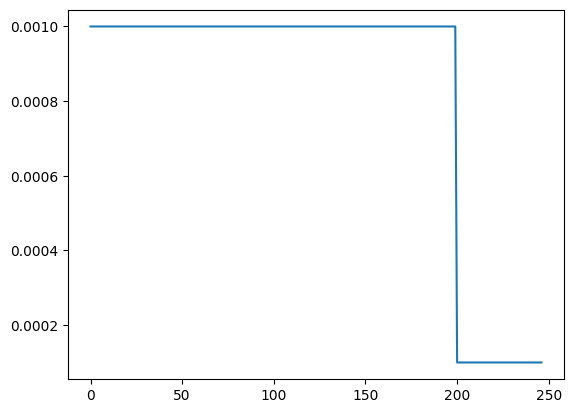

In [40]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

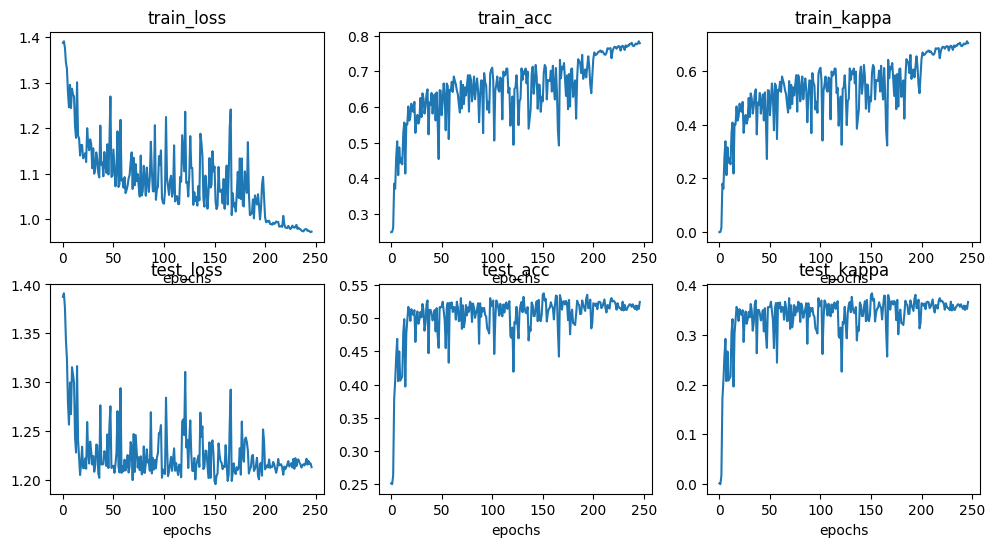

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

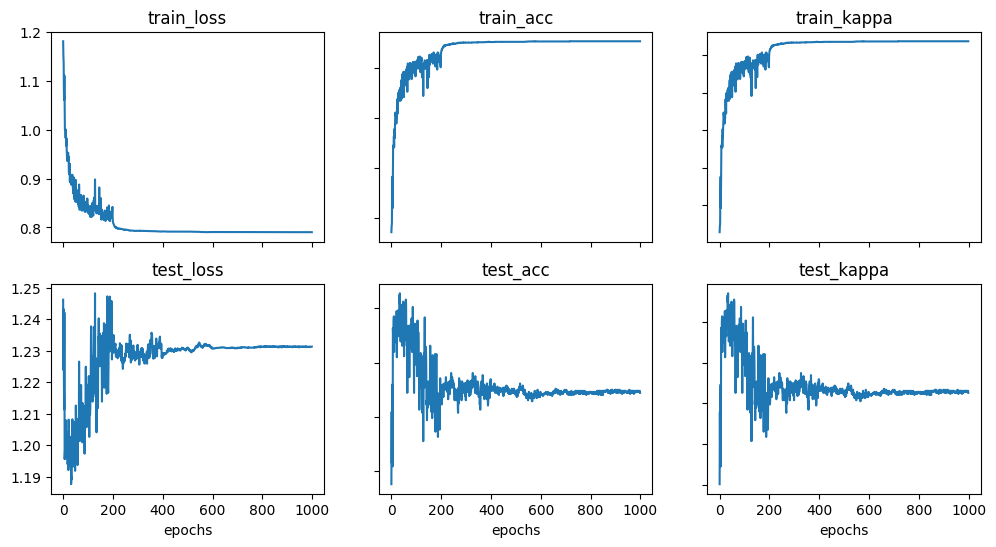

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()